In [11]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

In [2]:
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

# SIR Model (Model A)

In [3]:
# define functions ϕ of flows in the SIR model
fInfection(u,p,t)= p.cbeta*u.S*u.I/p.N
fRecovery(u,p,t)=u.I/p.trecovery
fWaningImmunityR(u,p,t)=u.R/p.twaning

# StockAndFlowp(stocks,
#               (flow=>function, upstream=>downstream) => stocks linked)
sir = StockAndFlowp((:S, :I, :R), 
   ((:Infection=>fInfection, :S=>:I) => (:S, :I), 
    (:Recovery=>fRecovery, :I=>:R) => :I, 
    (:WaningImmunityR=>fWaningImmunityR, :R=>:S) => :R))

StockAndFlowp with elements Flow = 1:3, Stock = 1:3, Link = 1:4
┌──────┬───┬───┬─────────────────┬──────────────────┐
│ Flow │ u │ d │           fname │               ϕf │
├──────┼───┼───┼─────────────────┼──────────────────┤
│    1 │ 1 │ 2 │       Infection │       fInfection │
│    2 │ 2 │ 3 │        Recovery │        fRecovery │
│    3 │ 3 │ 1 │ WaningImmunityR │ fWaningImmunityR │
└──────┴───┴───┴─────────────────┴──────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     I │
│     3 │     R │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 1 │
│    3 │ 2 │ 2 │
│    4 │ 3 │ 3 │
└──────┴───┴───┘

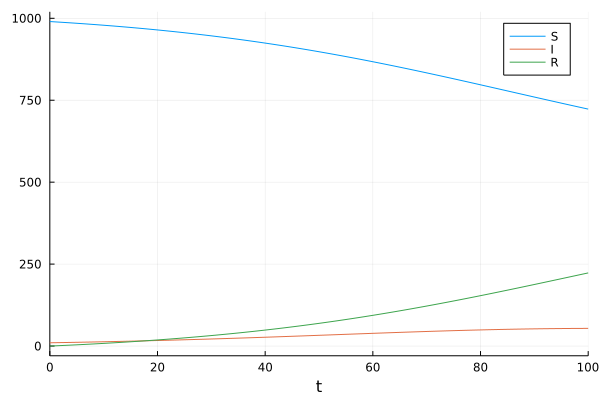

In [4]:
# define constant parameters
p_sir = LVector(
    cbeta=0.1, N=1000.0, trecovery=14.0, twaning = 2*365.0
)
# define initial values for stocks
u0_sir = LVector(
    S=990.0, I=10.0, R=0.0
)
# solve the ODEs
prob_sir = ODEProblem(vectorfield(sir),u0_sir,(0.0,100.0),p_sir);
sol_sir = solve(prob_sir,Tsit5(),abstol=1e-8);
plot(sol_sir)

# Hospitalized Model (Model B)

In [5]:
# define functions ϕ of flows in the Hospitalized model
fHICUAdmission(u,p,t) = u.I/p.trecovery * p.fractionH * p.fractionICU
fHNICUAdmission(u,p,t) = u.I/p.trecovery * p.fractionH * (1.0-p.fractionICU)
fOutICU(u,p,t) = u.HICU/p.tICU
fRecoveryH(u,p,t)= u.HNICU/p.tNICU

# Stock and flow diagram of hospitalized model
h = StockAndFlowp((:I, :HICU, :HNICU, :R), 
   ((:HICUAdmission=>fHICUAdmission, :I=>:HICU) => :I, 
    (:HNICUAdmission=>fHNICUAdmission, :I=>:HNICU) => :I, 
    (:OutICU=>fOutICU, :HICU=>:HNICU) => :HICU,
    (:RecoveryH=>fRecoveryH, :HNICU=>:R) => :HNICU))

StockAndFlowp with elements Flow = 1:4, Stock = 1:4, Link = 1:4
┌──────┬───┬───┬────────────────┬─────────────────┐
│ Flow │ u │ d │          fname │              ϕf │
├──────┼───┼───┼────────────────┼─────────────────┤
│    1 │ 1 │ 2 │  HICUAdmission │  fHICUAdmission │
│    2 │ 1 │ 3 │ HNICUAdmission │ fHNICUAdmission │
│    3 │ 2 │ 3 │         OutICU │         fOutICU │
│    4 │ 3 │ 4 │      RecoveryH │      fRecoveryH │
└──────┴───┴───┴────────────────┴─────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     I │
│     2 │  HICU │
│     3 │ HNICU │
│     4 │     R │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 1 │ 2 │
│    3 │ 2 │ 3 │
│    4 │ 3 │ 4 │
└──────┴───┴───┘

# Vaccine Model (Model C)

In [6]:
# define functions ϕ of flows in the Vaccine model
fFirstdoseVaccine(u,p,t) = u.S * p.rvaccine
fSeconddoseVaccine(u,p,t) = u.VP * p.rvaccine
fWaningImmunityVP(u,p,t) = u.VP / p.twaning
fWaningImmunityVF(u,p,t) = u.VF / p.twaning
fInfectionVP(u,p,t) = p.cbeta*u.VP*u.I*(1.0-p.eP)/p.N
fInfectionVF(u,p,t) = p.cbeta*u.VF*u.I*(1.0-p.eF)/p.N

# Stock and flow diagram of Vaccine model
v = StockAndFlowp((:S, :I, :VP, :VF), 
   ((:FirstdoseVaccine=>fFirstdoseVaccine, :S=>:VP) => :S, 
    (:SeconddoseVaccine=>fSeconddoseVaccine, :VP=>:VF) => :VP, 
    (:WaningImmunityVP=>fWaningImmunityVP, :VP=>:S) => :VP,
    (:WaningImmunityVF=>fWaningImmunityVF, :VF=>:VP) => :VF,
    (:InfectionVP=>fInfectionVP, :VP=>:I) => (:VP, :I),
    (:InfectionVF=>fInfectionVF, :VF=>:I) => (:VF, :I)))

StockAndFlowp with elements Flow = 1:6, Stock = 1:4, Link = 1:8
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 1 │ 3 │  FirstdoseVaccine │  fFirstdoseVaccine │
│    2 │ 3 │ 4 │ SeconddoseVaccine │ fSeconddoseVaccine │
│    3 │ 3 │ 1 │  WaningImmunityVP │  fWaningImmunityVP │
│    4 │ 4 │ 3 │  WaningImmunityVF │  fWaningImmunityVF │
│    5 │ 3 │ 2 │       InfectionVP │       fInfectionVP │
│    6 │ 4 │ 2 │       InfectionVF │       fInfectionVF │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     I │
│     3 │    VP │
│     4 │    VF │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 3 │ 2 │
│    3 │ 3 │ 3 │
│    4 │ 4 │ 4 │
│    5 │ 3 │ 5 │
│    6 │ 2 │ 5 │
│    7 │ 4 │ 6 │
│    8 │ 2 │ 6 │
└──────┴───┴───┘

In [7]:
# Compose SIR model (Model A), Hospitalized model (Model B) and Vaccine model (Model C)
# to generate the COVID-19 model

# Composition

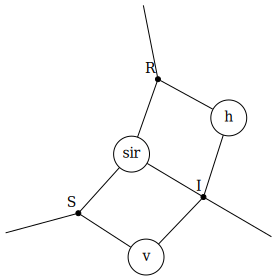

In [12]:
# define the UWD-algebra
covid = @relation (S, I, R) begin
    sir(S,I,R)
    h(I,R)
    v(S,I)
end;
display_uwd(covid)

In [13]:
# Open three Stock and Flow Diagrams as Structured Multicospan
opensir = Open(sir, [:S], [:I], [:R])
openh = Open(h, [:I], [:R])
openv = Open(v, [:S], [:I])
# Compose those three models according the UWD-algebra
openCOVID19 = oapply(covid, [opensir, openh, openv])
# Generate the composed model (Stock and Flow Diagram)
COVID19 = apex(openCOVID19)

Flow,u,d,fname,ϕf
1,1,2,Infection,fInfection
2,2,3,Recovery,fRecovery
3,3,1,WaningImmunityR,fWaningImmunityR
4,2,4,HICUAdmission,fHICUAdmission
5,2,5,HNICUAdmission,fHNICUAdmission
6,4,5,OutICU,fOutICU
7,5,3,RecoveryH,fRecoveryH
8,1,6,FirstdoseVaccine,fFirstdoseVaccine
9,6,7,SeconddoseVaccine,fSeconddoseVaccine
10,6,1,WaningImmunityVP,fWaningImmunityVP


In [14]:
# after composition, some flows' functions may change
fRecovery(u,p,t)=u.I/p.trecovery * (1.0-p.fractionH)

fRecovery (generic function with 1 method)

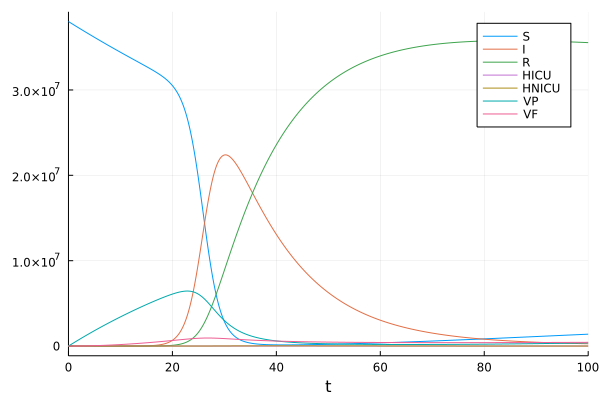

In [15]:
# define constant parameters
p_COVID19 = LVector(
    cbeta=0.8, N=38010001.0, trecovery=12.22, twaning=2*365.0,
    fractionH=0.002, fractionICU=0.23, tICU=6.0, tNICU = 12.0,
    rvaccine=0.01, eP=0.6, eF=0.85   
)
# define initial values for stocks
u0_COVID19 = LVector(
    S=38010000.0, I=1.0, R=0.0, HICU=0.0, HNICU=0.0, VP=0.0, VF=0.0
)
# solve the ODEs
prob_COVID19 = ODEProblem(vectorfield(COVID19),u0_COVID19,(0.0,100.0),p_COVID19);
sol_COVID19 = solve(prob_COVID19,Tsit5(),abstol=1e-8);
plot(sol_COVID19)

In [16]:
sol_COVID19

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 49-element Vector{Float64}:
   0.0
   3.7206169202669084e-11
   4.092678612293599e-10
   4.1298847814962676e-9
   4.1336053984165345e-8
   4.133977460108561e-7
   4.1340146662777635e-6
   4.1340183868946836e-5
   0.0004134018758956375
   0.0041340187961625445
   0.04134018799883161
   0.2008149842114953
   0.5033705151080503
   ⋮
  38.03684292143219
  40.65345742280623
  43.74019863906594
  47.663195537681844
  52.547289607854516
  57.95868656313147
  64.23815146201342
  71.40257434579826
  79.8609974665537
  88.88515780704378
  98.02906703797457
 100.0
u: 49-element Vector{LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :HICU, :HNICU, :VP, :VF)}}:
 7-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :HICU, :HNICU, :VP, :VF)}:
     :S => 3.801e7
     :I => 1.0
     :R => 0.0
  :HICU => 0.0
 :HNICU => 0.0
    :VP => 0.0
    :VF => 0.0
 7-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :HICU, :

# Dynamical Variables and Flows calculation based on model state

In [18]:
# Flow of FirstdoseVaccine
ϕFirstdoseVaccine = map(x->fFirstdoseVaccine(sol_COVID19.u[x],p_COVID19,sol_COVID19.t[x]),collect(1:length(sol_COVID19.t)))

49-element Vector{Float64}:
 380100.0
 380099.9999998586
 380099.9999984444
 380099.9999843023
 380099.99984288134
 380099.9984286719
 380099.98428657756
 380099.84286566736
 380098.428659855
 380084.2869307199
 379942.90253251715
 379337.5711829883
 378192.1474972596
      ⋮
   1700.4083683727201
   1373.9276145915326
   1435.1366926403152
   1783.9436091334437
   2429.0173093197086
   3332.3228701066882
   4584.612475789702
   6232.143656575054
   8393.813438503304
  10845.606413629968
  13371.897043995175
  13913.03773177316